In [1]:
import pandas as pd
# df_transformed is  our input for the model with terms extracted from nites(~1mil)
df_transformed_path = "structured_diagnosis"
df_transformed = pd.read_csv(df_transformed_path)

#drop nan diagnosis df_transformed
df_transformed = df_transformed.dropna(subset=['discharge_diag'])

#df_output is the output from model which is the mapped terms from the extracted terms
df_output_path = "structured_diagnosis_mappings"
df_output = pd.read_csv(df_output_path)

#drop nan diagnosis df_output
df_output = df_output[df_output['Diagnosis'] != "NaN"]
df_output = df_output.dropna(subset=['Diagnosis'])

In [2]:
# file path to diagnosis file in MIMIC-IV. ground truth
file_path = '/data0/mimiciv/0.4/hosp/diagnoses_icd.csv.gz'

# Reading the gzipped CSV file directly into a DataFrame
mimic_diagnosis = pd.read_csv(file_path, compression='gzip')

# Number of unique patients
num_unique_patients = mimic_diagnosis['subject_id'].nunique()

print(f"Unique patients: {num_unique_patients}")

Unique patients: 221122


In [3]:
#concept and patient stats
import matplotlib.pyplot as plt

# Calculate the values
unique_patients_transformed = df_transformed['subject_id'].nunique()#extracted
unique_patients_output = df_output['Subject_ID'].nunique()#umls mapped

unique_concepts_transformed = df_transformed['discharge_diag'].nunique()
unique_concepts_output = df_output['Diagnosis'].nunique()

total_concepts_transformed = df_transformed['discharge_diag'].count()
total_concepts_output = df_output['Diagnosis'].count()

# Display calculated values
print(f"Unique Patients extracted from notes: {unique_patients_transformed}")
print(f"Unique Patients aftr mapping : {unique_patients_output}")
print(f"Unique Diagnosis Concepts extracted from notes: {unique_concepts_transformed}")
print(f"Unique Diagnosis Concepts aftr mapping: {unique_concepts_output}")
print(f"Total Diagnosis Concepts extracted from notes: {total_concepts_transformed}")
print(f"Total Diagnosis Concepts aftr mapping: {total_concepts_output}")


Unique Patients extracted from notes: 145219
Unique Patients aftr mapping : 142468
Unique Diagnosis Concepts extracted from notes: 405158
Unique Diagnosis Concepts aftr mapping: 372339
Total Diagnosis Concepts extracted from notes: 1078656
Total Diagnosis Concepts aftr mapping: 1015591


In [4]:
#total umls cuis, icd codes, snomed
df_output.head(5)

# Count non-NaN values in UMLS_CUI column
non_nan_umls_cui_count = df_output['UMLS_CUI'].notna().sum()

# Count occurrences where 'code' is in ('ICD10', 'ICD10CM')
icd10_count = df_output[df_output['sab'].isin(['ICD10', 'ICD10CM'])].shape[0]

# Count occurrences where 'code' is 'SNOMEDCT_US'
snomedct_us_count = df_output[df_output['sab'] == 'SNOMEDCT_US'].shape[0]

# Display the results
print(f"Total non-NaN UMLS_CUI: {non_nan_umls_cui_count}")
print(f"Total ICD10 or ICD10CM codes: {icd10_count}")
print(f"Total SNOMEDCT_US codes: {snomedct_us_count}")
# Count unique Subject_IDs for rows where 'sab' is in ('ICD10', 'ICD10CM')
unique_subject_ids_icd10 = df_output[df_output['sab'].isin(['ICD10', 'ICD10CM'])]['Subject_ID'].nunique()
snomed_only_subjects = df_output.loc[
    df_output['Subject_ID'].isin(
        df_output.loc[df_output['sab'] == 'SNOMEDCT_US', 'Subject_ID']
    ) & 
    ~df_output['Subject_ID'].isin(
        df_output.loc[df_output['sab'].isin(['ICD10', 'ICD10CM']), 'Subject_ID']
    ),
    'Subject_ID'
].nunique()

# Calculate the remaining portion (NaN or other codes)
remaining_count = non_nan_umls_cui_count - (icd10_count + snomedct_us_count)

# Display the counts
print(f"Total non-NaN UMLS_CUI concepts: {non_nan_umls_cui_count}")
print(f"Total ICD10 or ICD10CM codes concepts: {icd10_count}")
print(f"Total SNOMEDCT_US codes concepts: {snomedct_us_count}")
print(f"Remaining concepts(No ICD10/SNOMEDCT codes, only UMLS CUIs): {remaining_count}")
print(f"Total unique Subject_IDs for ICD10/ICD10CM: {unique_subject_ids_icd10}")
print(f"Total unique Subject_IDs for SNOMEDCT_US: {snomed_only_subjects}")


Total non-NaN UMLS_CUI: 1015591
Total ICD10 or ICD10CM codes: 529580
Total SNOMEDCT_US codes: 376519
Total non-NaN UMLS_CUI concepts: 1015591
Total ICD10 or ICD10CM codes concepts: 529580
Total SNOMEDCT_US codes concepts: 376519
Remaining concepts(No ICD10/SNOMEDCT codes, only UMLS CUIs): 109492
Total unique Subject_IDs for ICD10/ICD10CM: 114501
Total unique Subject_IDs for SNOMEDCT_US: 23933


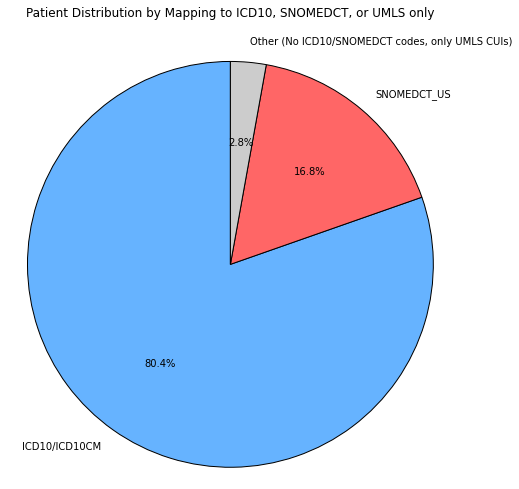

In [6]:
# Calculate patient counts for each category for the pie chart
# Unique patients mapped to ICD10/ICD10CM
unique_patients_icd10 = df_output[df_output['sab'].isin(['ICD10', 'ICD10CM'])]['Subject_ID'].nunique()

# Unique patients mapped to SNOMEDCT_US (excluding those already counted in ICD10 since prioritized)
unique_patients_snomed = snomed_only_subjects

# Patients with UMLS CUIs but no ICD10 or SNOMEDCT mapping
patients_with_umls = set(df_output.loc[df_output['UMLS_CUI'].notna(), 'Subject_ID'])
patients_icd10_or_snomed = set(df_output.loc[df_output['sab'].isin(['ICD10', 'ICD10CM', 'SNOMEDCT_US']), 'Subject_ID'])
unique_patients_other = len(patients_with_umls - patients_icd10_or_snomed)

# Replace sizes with patient counts
sizes = [unique_patients_icd10, unique_patients_snomed, unique_patients_other]

# Labels and colors remain the same
labels = ['ICD10/ICD10CM', 'SNOMEDCT_US', 'Other (No ICD10/SNOMEDCT codes, only UMLS CUIs)']
colors = ['#66b3ff', '#ff6666', '#cccccc']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Patient Distribution by Mapping to ICD10, SNOMEDCT, or UMLS only', pad=30)

# Display the chart
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.show()


In [7]:
#see what the mapped table looks like
df_output.head(5)

,Unnamed: 0,Subject_ID,hadm_id,Diagnosis,UMLS_CUI,UMLS_Name,Score,code,str,tty,sab
0,0,10000032,22595853,Ascites from Portal HTN,C0003962,Ascites,0.988981,R18,Ascites,AB,ICD10CM
1,17,10000032,22841357,"HCV cirrhosis, HIV, hyponatremia, COPD",C0020625,Hyponatremia,0.989849,E87.1,Sodium [Na] deficiency,ET,ICD10CM
2,5,10000032,22841357,diuretic refractory ascites,C0003962,Ascites,0.988981,R18,Ascites,AB,ICD10CM
3,46,10000032,25742920,Decompensated HCV cirrhosis,C0205434,Decompensated,0.972250,5650002,Decompensated,PT,SNOMEDCT_US
4,53,10000032,25742920,Hyponatremia,C0020625,Hyponatremia,0.989849,E87.1,Sodium [Na] deficiency,ET,ICD10CM


In [8]:
#see what the mimic-iv ground truth table looks like
import pandas as pd
# file path to diagnosis file
file_path = '/data0/mimiciv/0.4/hosp/diagnoses_icd.csv.gz'

# Reading the gzipped CSV file directly into a DataFrame
mimic_diagnosis = pd.read_csv(file_path, compression='gzip')

# Display the first few rows
mimic_diagnosis.head(10)


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,65801,9
1,11603789,25552978,4,64881,9
2,11603789,25552978,5,V270,9
3,11603789,25552978,1,65221,9
4,11603789,25552978,2,64421,9
5,16809467,29803749,4,66982,9
6,16809467,29803749,1,64511,9
7,16809467,29803749,2,64811,9
8,16809467,29803749,5,V270,9
9,16809467,29803749,3,2449,9


In [9]:
#prep--> converting/crosswalking the mimic-iv icd9 to icd 10

# Step 1: Prepare crosswalk_df
crosswalk_df = pd.read_csv("icd9_to_10.csv")

# Remove periods from the 'code' column
crosswalk_df_updated = crosswalk_df.copy()
crosswalk_df_updated['source_code'] = crosswalk_df_updated['source_code'].str.replace('.', '', regex=False)
crosswalk_df_updated['target_code'] = crosswalk_df_updated['target_code'].str.replace('.', '', regex=False)

mimic_diagnosis['icd_code'] = mimic_diagnosis['icd_code'].astype(str)
crosswalk_df_updated['source_code'] = crosswalk_df_updated['source_code'].astype(str)
mimic_diagnosis['icd_code'] = mimic_diagnosis['icd_code'].str.strip()
crosswalk_df_updated['source_code'] = crosswalk_df_updated['source_code'].str.strip()

mimic_diagnosis = mimic_diagnosis.merge(crosswalk_df_updated, 
                                        left_on='icd_code', 
                                        right_on='source_code', 
                                        how='left')
# Step 3: Replace icd_code with target_code where merged, else keep original icd_code
mimic_diagnosis['icd_code'] = mimic_diagnosis['target_code'].fillna(mimic_diagnosis['icd_code'])

# Update icd_version to '10_cw' where target_code was used
mimic_diagnosis.loc[mimic_diagnosis['target_code'].notna(), 'icd_version'] = '10_cw'

mimic_diagnosis = mimic_diagnosis[['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version']]

unique_subjects = mimic_diagnosis['subject_id'].nunique()
total_unique_subjects = mimic_diagnosis['subject_id'].nunique()
print(f"Unique subject IDs: {unique_subjects}")


mimic_diagnosis['icd_version'] = mimic_diagnosis['icd_version'].apply(lambda x: str(x).strip() if x is not None else '')
mimic_diagnosis = mimic_diagnosis[mimic_diagnosis['icd_version'].isin(['10', '10_cw'])]

unique_subjects = mimic_diagnosis['subject_id'].nunique()
print(f"Unique subject IDs with only ICD10: {unique_subjects}")

mimic_diagnosis.head()


/tmp/ipykernel_1256546/3951060899.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10_cw' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  mimic_diagnosis.loc[mimic_diagnosis['target_code'].notna(), 'icd_version'] = '10_cw'


Unique subject IDs: 221122
Unique subject IDs with only ICD10: 218593


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,11603789,25552978,3,O410,10_cw
1,11603789,25552978,4,O99810,10_cw
2,11603789,25552978,5,Z370,10_cw
3,11603789,25552978,1,O321XX0,10_cw
4,11603789,25552978,2,O601,10_cw


In [10]:
#FROM the mapped data by scispacy choose icd10 cdes and remove the period as grund trth doesnot have period

# Filter rows where 'sab' is 'ICD10CM' or 'ICD10'
df_output_filtered = df_output[df_output['sab'].isin(['ICD10CM', 'ICD10'])]

# Remove periods from the 'code' column
df_output_updated = df_output_filtered.copy()
df_output_updated['code'] = df_output_updated['code'].str.replace('.', '', regex=False)

# Get total counts and unique Subject_ID counts
total_rows = df_output_updated.shape[0]
unique_subject_ids = df_output_updated['Subject_ID'].nunique()

print(f"Total rows: {total_rows}")
print(f"Unique Subject_IDs: {unique_subject_ids}")

df_output_updated.head()

Total rows: 529580
Unique Subject_IDs: 114501


,Unnamed: 0,Subject_ID,hadm_id,Diagnosis,UMLS_CUI,UMLS_Name,Score,code,str,tty,sab
0,0,10000032,22595853,Ascites from Portal HTN,C0003962,Ascites,0.988981,R18,Ascites,AB,ICD10CM
1,17,10000032,22841357,"HCV cirrhosis, HIV, hyponatremia, COPD",C0020625,Hyponatremia,0.989849,E871,Sodium [Na] deficiency,ET,ICD10CM
2,5,10000032,22841357,diuretic refractory ascites,C0003962,Ascites,0.988981,R18,Ascites,AB,ICD10CM
4,53,10000032,25742920,Hyponatremia,C0020625,Hyponatremia,0.989849,E871,Sodium [Na] deficiency,ET,ICD10CM
5,30,10000032,29079034,Acute Kidney Injury,C0022660,"Kidney Failure, Acute",0.975594,N179,"Acute kidney failure, unspecified",PT,ICD10CM


In [13]:
#compare the total match in ground trth and generated

# Create a list of unique codes for each subject_id in df_output_updated
df_output_codes = df_output_updated.groupby('Subject_ID')['code'].apply(lambda x: list(set(x))).reset_index()

# Create a list of unique icd_codes for each subject_id in mimic_diagnosis
mimic_codes = mimic_diagnosis.groupby('subject_id')['icd_code'].apply(lambda x: list(set(x))).reset_index()

# Merge the two dataframes on subject_id
merged_df = pd.merge(df_output_codes, mimic_codes, left_on='Subject_ID', right_on='subject_id', how='inner')

# Function to find matches between two lists of codes
def find_matches(row):
    return list(set(row['code']).intersection(set(row['icd_code'])))

# Apply the function to create a new column with matched codes
merged_df['matched_icd_code'] = merged_df.apply(find_matches, axis=1)




In [14]:
merged_df.head(10)

,Subject_ID,code,subject_id,icd_code,matched_icd_code
0,10000032,"[J449, E875, N179, K7460, I959, R18, E871]",10000032,"[J449, R197, K74, E875, R64, K766, F431, F1720...","[J449, E871, E875]"
1,10000084,[F03],10000084,"[G3183, F0280, G20, R609, E785, R296, R441, Z8...",[]
2,10000117,"[R1310, K21]",10000117,"[R0989, Y92480, K219, Z87442, S72012A, Y93K1, ...",[R1310]
3,10000248,[D66],10000248,"[S0093, Y92410, V00311, S301, D649]",[]
4,10000764,"[S022, R040]",10000764,"[I252, N179, I739, I35, R0902, Z7902, Z87891, ...",[R040]
5,10000826,"[K766, R18, K701]",10000826,"[J918, E876, J90-J94, J189, F1020, K766, M545,...",[K766]
6,10000883,"[F32A, F419]",10000883,"[F332, F438]",[]
7,10000935,[R110],10000935,"[E861, M545, R918, F40, E860, R112, R627, I498...",[]
8,10000980,"[E11, J449, I2510, E14, I739, N189, N181, I160...",10000980,"[K5730, I129, K2970, I20, Z8673, D500, Z7982, ...","[J449, I2510, E785]"
9,10001176,[E11],10001176,"[G92, R197, I252, K219, R0902, E78, J159, I10-...",[]


Total rows in the inner join: 102539
Unique subject_ids in the inner join: 102539
Count of rows with non-empty matched_icd_code: 59742


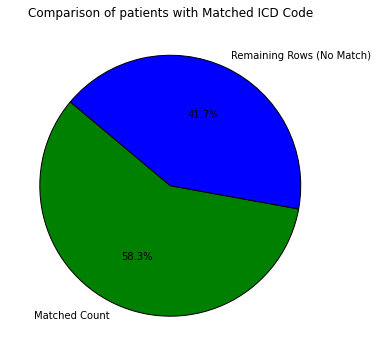

In [15]:
total_rows = merged_df.shape[0]  # Get total number of rows
unique_subject_ids = merged_df['Subject_ID'].nunique()  # Get count of unique subject_ids
matched_count = merged_df[merged_df['matched_icd_code'].apply(lambda x: len(x) > 0)].shape[0]
print(f"Total rows in the inner join: {total_rows}")
print(f"Unique subject_ids in the inner join: {unique_subject_ids}")
print(f"Count of rows with non-empty matched_icd_code: {matched_count}")

# Labels and values for pie chart
labels = ['Matched Count', 'Remaining Rows (No Match)']
values = [matched_count, total_rows - matched_count]  # Remaining rows that don't have matches

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'blue'], wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Comparison of patients with Matched ICD Code')
plt.show()


In [16]:
#ROLLUP COMPARISON
import pandas as pd

# Merge on subject_id
merged_df = pd.merge(df_output_codes, mimic_codes, left_on='Subject_ID', right_on='subject_id', how='inner')

# Modified match function that compares first 3 characters of codes
def find_matches(row):
    code_prefixes = set(code[:3] for code in row['code'] if isinstance(code, str))
    icd_prefixes = set(icd[:3] for icd in row['icd_code'] if isinstance(icd, str))
    # Intersect the prefixes
    matching_prefixes = code_prefixes.intersection(icd_prefixes)
    # Find actual ICD codes from icd_code list that match on prefix
    matched = [icd for icd in row['icd_code'] if icd[:3] in matching_prefixes]
    return matched

# Apply the modified matching function
merged_df['matched_icd_code'] = merged_df.apply(find_matches, axis=1)

# Count how many matches per patient
merged_df['num_matches'] = merged_df['matched_icd_code'].apply(len)

# Show result
print(merged_df[['Subject_ID', 'matched_icd_code', 'num_matches']].head())


   Subject_ID                    matched_icd_code  num_matches
0    10000032  [J449, K74, E875, R188, I95, E871]            6
1    10000084                                  []            0
2    10000117                       [K219, R1310]            2
3    10000248                                  []            0
4    10000764                              [R040]            1


Total rows in the inner join: 102539
Unique subject_ids in the inner join: 102539
Count of rows with non-empty matched_icd_code: 85185


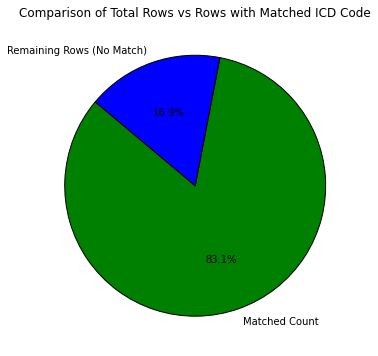

In [17]:
total_rows = merged_df.shape[0]  # Get total number of rows
unique_subject_ids = merged_df['Subject_ID'].nunique()  # Get count of unique subject_ids
matched_count = merged_df[merged_df['matched_icd_code'].apply(lambda x: len(x) > 0)].shape[0]
print(f"Total rows in the inner join: {total_rows}")
print(f"Unique subject_ids in the inner join: {unique_subject_ids}")
print(f"Count of rows with non-empty matched_icd_code: {matched_count}")

# Labels and values for pie chart
labels = ['Matched Count', 'Remaining Rows (No Match)']
values = [matched_count, total_rows - matched_count]  # Remaining rows that don't have matches

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'blue'], wedgeprops={'edgecolor': 'black'})

# Title
plt.title('Comparison of Total Rows vs Rows with Matched ICD Code')
plt.show()


In [16]:
merged_df.head(50)

,Subject_ID,code,subject_id,icd_code,matched_icd_code,num_matches
0,10000032,"[K7460, J449, R18, E871, E875, N179, I959]",10000032,"[I95, F17200, R64, R188, J449, F431, Z87891, K...","[I95, R188, J449, K74, E871, E875]",6
1,10000084,[F03],10000084,"[R4182, R609, Z8546, F0280, R441, E785, R296, ...",[],0
2,10000117,"[R1310, K21]",10000117,"[Z87442, M810, S72012A, I341, Z7901, Z87891, E...","[K219, R1310]",2
3,10000248,[D66],10000248,"[S0093, S301, V00311, D649, Y92410]",[],0
4,10000764,"[R040, S022]",10000764,"[I214, I739, W1849XA, Z87891, I2510, I10-I16, ...",[R040],1
5,10000826,"[K701, K766, R18]",10000826,"[F17200, K5909, R188, E876, F1020, J189, K703,...","[R188, K703, K7010, K766]",4
6,10000883,"[F32A, F419]",10000883,"[F438, F332]",[],0
7,10000935,[R110],10000935,"[R05, F40, Z90710, Z800, R112, Z791, R918, G89...",[R112],1
8,10000980,"[I639, I739, I509, N181, J449, N189, I2510, E7...",10000980,"[I2542, I340, Z794, J449, K2970, Z7902, M1A9XX...","[I2542, J449, N184, E1151, E11319, I5032, E785...",18
9,10001176,[E11],10001176,"[I2510, I10-I16, R911, R197, R112, E871, J159,...",[],0


In [18]:
#scatter plot for type of diagnosis predictions by model. dont do the above step to do this. the above converts codes to list. so instead skip that

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Keep individual rows for ICD codes (without grouping into lists)
df_output_codes = df_output_updated[['Subject_ID', 'code']].drop_duplicates()
mimic_codes = mimic_diagnosis[['subject_id', 'icd_code', 'seq_num']].drop_duplicates()  # Include seq_num early

# Merge on Subject_ID and ICD Code directly (no lists)
merged_df = pd.merge(df_output_codes, mimic_codes, 
                     left_on=['Subject_ID', 'code'], 
                     right_on=['subject_id', 'icd_code'], 
                     how='inner')

print("Merge complete")

# Extract only the relevant columns
final_merged_df = merged_df[['Subject_ID', 'code', 'subject_id', 'icd_code', 'seq_num']]

# **Keep only the row with the minimum seq_num for each unique Subject_ID**
final_merged_df = final_merged_df.loc[final_merged_df.groupby('Subject_ID')['seq_num'].idxmin()]

# **Cap seq_num at 15: If seq_num > 15, set it to 15**
final_merged_df['seq_num'] = final_merged_df['seq_num'].apply(lambda x: min(x, 15))

# Save to CSV
file_path = 'final_merged_output_seq_num_min_seq_capped.csv'
final_merged_df.to_csv(file_path, index=False)
print(f"DataFrame successfully exported to {file_path}")

# Compute counts of unique Subject_IDs per seq_num for plotting
seq_counts = final_merged_df.groupby('seq_num')['Subject_ID'].nunique().reset_index()
seq_counts = seq_counts.sort_values(by='seq_num', ascending=True)  # Ensure correct order

# **Calculate total unique matched patients**
total_unique_subjects = final_merged_df['Subject_ID'].nunique()

# **Compute proportion of patients per seq_num**
seq_counts['total_matched_patients'] = total_unique_subjects
seq_counts['proportion'] = seq_counts['Subject_ID'] / total_unique_subjects

# Print counts for verification
print(seq_counts)


Merge complete
DataFrame successfully exported to final_merged_output_seq_num_min_seq_capped.csv
    seq_num  Subject_ID  total_matched_patients  proportion
0         1       24574                   59742    0.411335
1         2       10249                   59742    0.171554
2         3        6649                   59742    0.111295
3         4        4519                   59742    0.075642
4         5        3282                   59742    0.054936
5         6        2422                   59742    0.040541
6         7        1810                   59742    0.030297
7         8        1417                   59742    0.023719
8         9        1111                   59742    0.018597
9        10         829                   59742    0.013876
10       11         608                   59742    0.010177
11       12         490                   59742    0.008202
12       13         401                   59742    0.006712
13       14         293                   59742    0.004904
14 

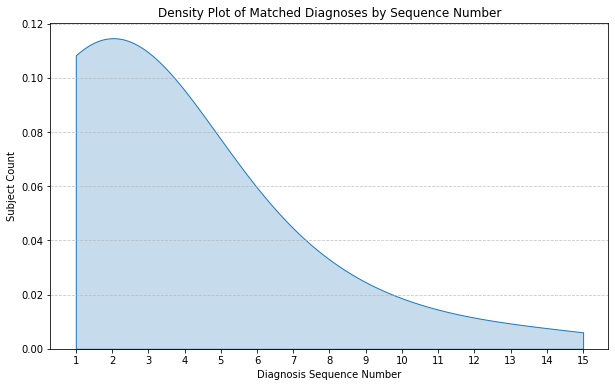

In [19]:
plt.figure(figsize=(10, 6))

# Use weights to reflect actual subject counts
sns.kdeplot(data=seq_counts, x="seq_num", weights=seq_counts["Subject_ID"], 
            fill=True, bw_adjust=1, clip=(1, 15))  

plt.xlabel("Diagnosis Sequence Number")
plt.ylabel("Subject Count")  # Now showing actual counts
plt.title("Density Plot of Matched Diagnoses by Sequence Number")

plt.xticks(range(1, 16))  # Restrict x-axis to 1-15
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

